In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns # For KDE 
import matplotlib.pyplot as plt # For general plots

In [3]:
import warnings
warnings.filterwarnings("ignore") # Removing UserWarnings.

## Dataset Loading

In [4]:
trainData = pd.read_csv("./dataset/train.csv")
testData = pd.read_csv("./dataset/test.csv")

## Exploratory Data Analysis

In [5]:
trainData.head(10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,1551
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,255
9,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981049,40.744339,-73.973000,40.789989,N,1225


In [6]:
missing_values = trainData.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64


The data has no missing values.

In [7]:
data_types = trainData.dtypes
print("Data types of columns:\n", data_types)

Data types of columns:
 id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object


## Data Visualization

In [8]:
numBins = 500
figureSize = (8,6)

Since time of travelling is very important, we can divide the day into 4 segments of 6 hours each and then 
analyze the distribution of trip durations in each segment. Along with stuff like the mean and median, as 
well as the geographic distribution of the locations.

In [9]:
trainData['pickup_datetime'] = pd.to_datetime(trainData['pickup_datetime'])
trainData['dropoff_datetime'] = pd.to_datetime(trainData['dropoff_datetime'])

def getTimeZone(time):
    hour = time.hour
    if hour > 6 and hour <= 12:
        return "Morning"
    elif hour > 12 and hour <= 18:
        return "Afternoon"
    elif hour > 18 and hour <= 24:
        return "Evening"
    else:
        return "Night"

# Storing the new column
trainData['time_zone'] = trainData['pickup_datetime'].apply(getTimeZone)

### Trip Duration Distribution

## 1. Histogram of Trip Duration along with KDE
**Justification**: A histogram with a kernel density estimate (KDE) is effective for visualizing the distribution.

**Insights**: This graph may reveal whether most trips are short or long, indicating common trip patterns.

> __Note__ : Since the simple plot with time duration is too constricted to be of any use, I have simply 
plotted the log-transformed distribution totally and in each time zone.

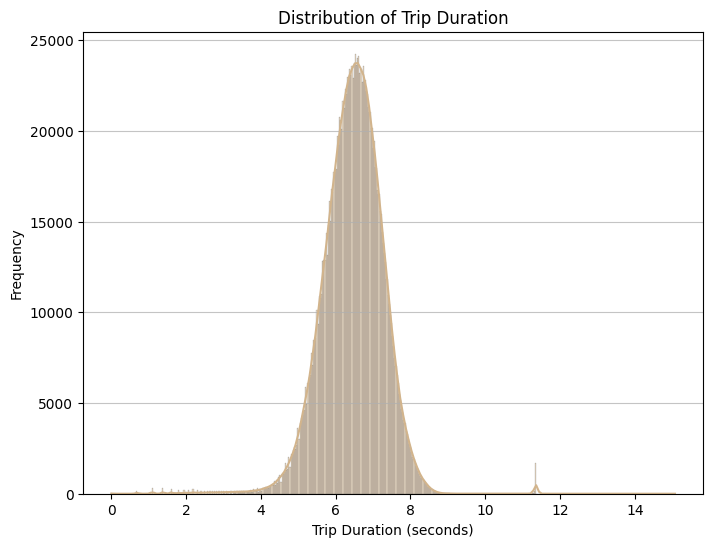

In [10]:
plt.figure(figsize=figureSize)
sns.histplot(np.log(trainData['trip_duration']), bins=numBins, color='tan', kde=True)
plt.title('Distribution of Trip Duration')
plt.xlabel('Trip Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [11]:
# Time zone wise statistics.
mean_time_zone = trainData.groupby('time_zone')['trip_duration'].mean()
print(mean_time_zone)
median_time_zone = trainData.groupby('time_zone')['trip_duration'].median()
print(median_time_zone)

time_zone
Afternoon    1049.654825
Evening       921.166859
Morning       934.274147
Night         887.091468
Name: trip_duration, dtype: float64
time_zone
Afternoon    706.0
Evening      651.0
Morning      669.0
Night        585.0
Name: trip_duration, dtype: float64


### Grouping the data 
Since there is a lot of variation in the trip duration, we can group the data into different time zones.
These help in visualizing the distribution of trip durations in different time zones. Which enables one to 
understand the common trip patterns, traffic patterns, etc.

## Working In Each Time Zone

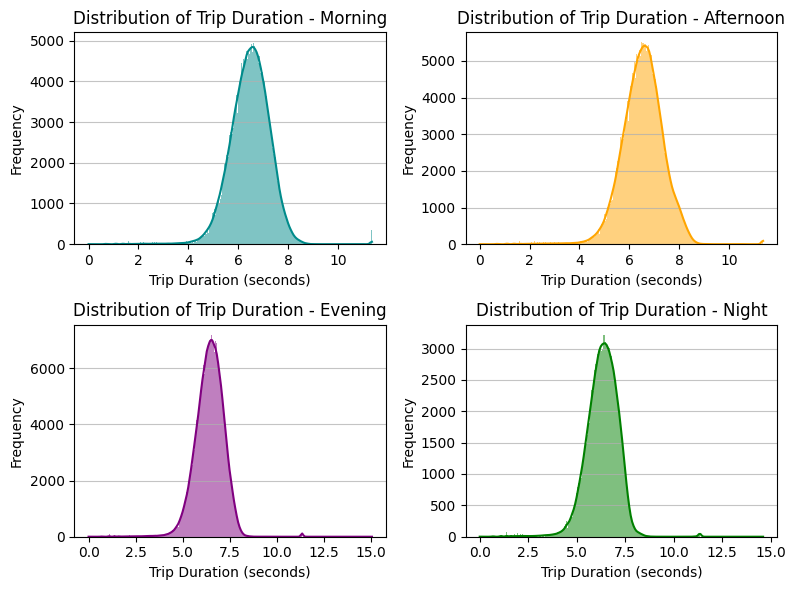

In [12]:
trainData['log_trip_duration'] = np.log(trainData['trip_duration'])

fig, axs = plt.subplots(2, 2, figsize=figureSize)

colors = ['darkcyan', 'orange', 'purple', 'green']
time_zones = ['Morning', 'Afternoon', 'Evening', 'Night']
axs_flat = axs.flatten()  

# Plot histograms for each time zone
for ax, color, zone in zip(axs_flat, colors, time_zones):
    sns.histplot(data = trainData[trainData['time_zone'] == zone], x='log_trip_duration',
                 bins=numBins, color=color, kde=True, ax=ax, edgecolor='none')
    ax.set_title(f'Distribution of Trip Duration - {zone}')
    ax.set_xlabel('Trip Duration (seconds)')
    ax.set_ylabel('Frequency')
    ax.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

## 2. Scatter Plot of Pickup vs Dropoff Locations using Seaborn
__Justification__ : A scatter plot is effective for visualizing the geographical distribution of pickup and dropoff locations.
It can also help in finding the prominent hotspots and how they are distributed geographically.

__Insights__ : This graph can reveal patterns in trip origins and destinations across NYC. If plotted across different times
in a day, it can also show potential traffic patterns, as well as the distribution of trips across different neighborhoods.

> __Note__ : We do it again in groups corresponding to the various time zones.

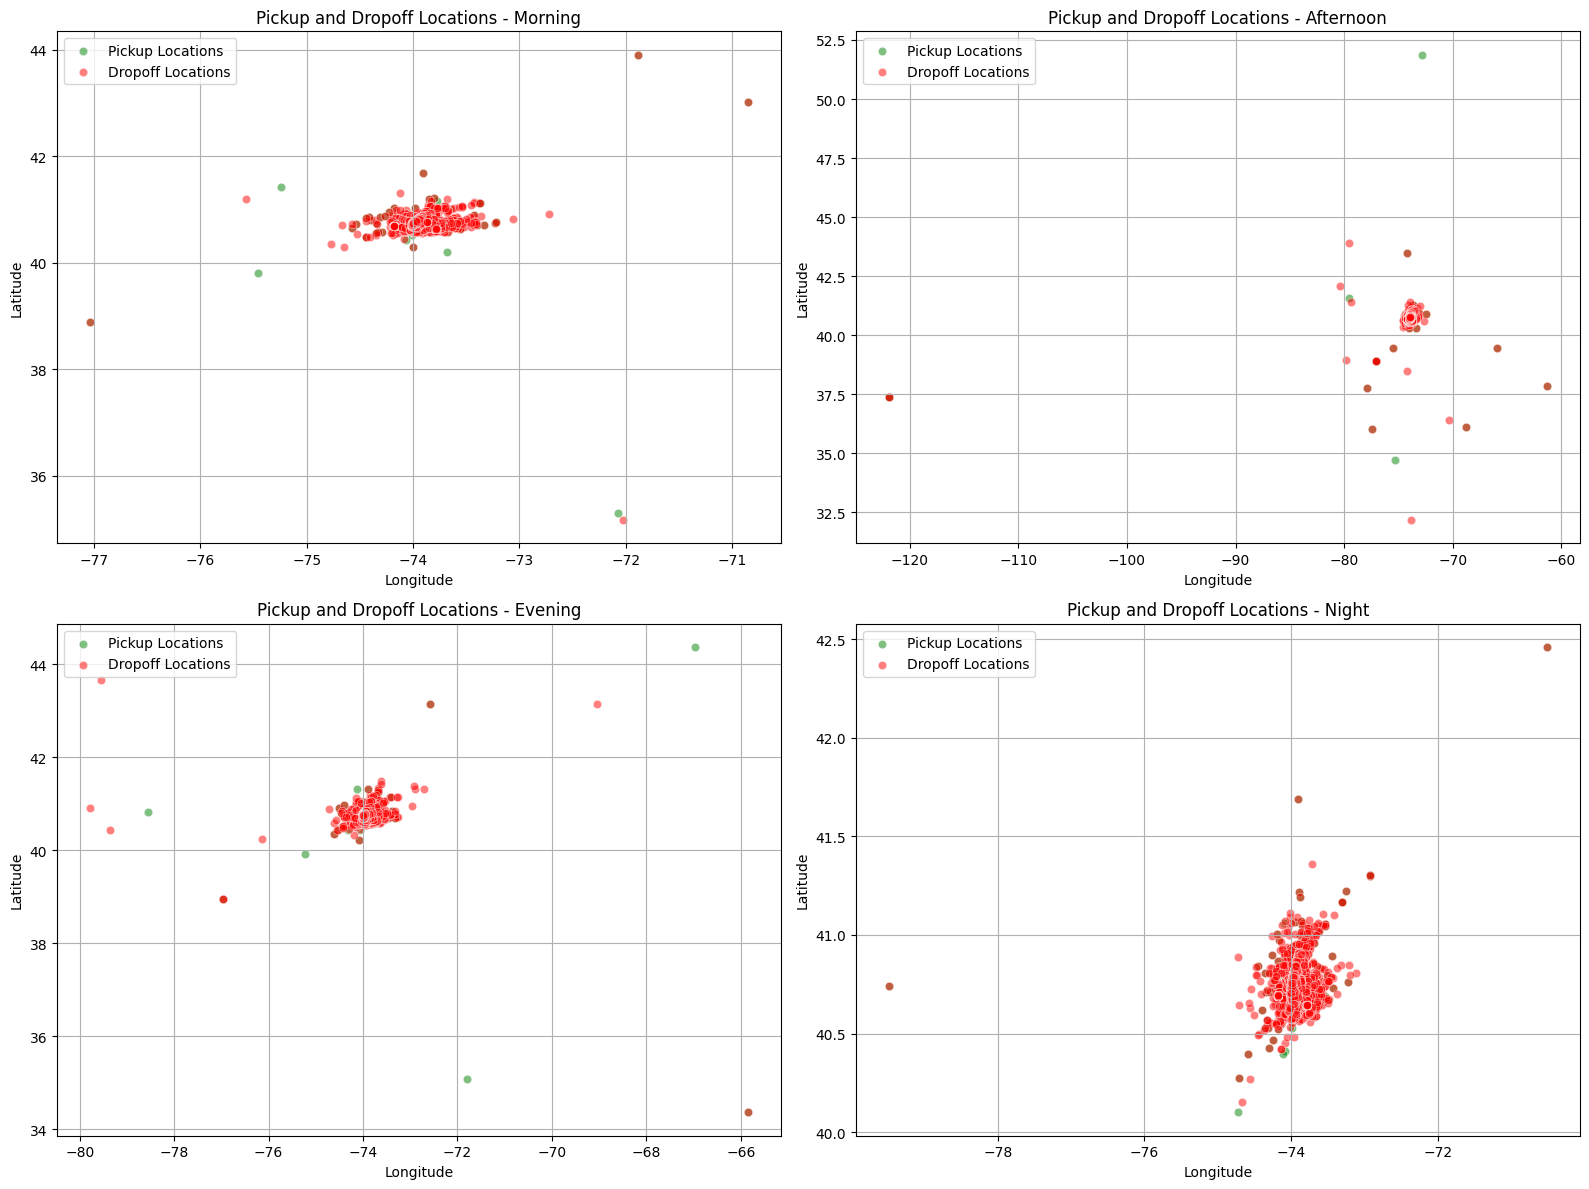

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Define time zones for plotting
time_zones = ['Morning', 'Afternoon', 'Evening', 'Night']
colors = ['green', 'red']

# Plotting scatter plots for each time zone
for ax, zone in zip(axs.flatten(), time_zones):
    # Filter data for the current time zone
    zone_data = trainData[trainData['time_zone'] == zone]

    # Scatter plot for pickup locations
    sns.scatterplot(x='pickup_longitude', y='pickup_latitude', data=zone_data,
                    alpha=0.5, label='Pickup Locations', color=colors[0], ax=ax)

    # Scatter plot for dropoff locations
    sns.scatterplot(x='dropoff_longitude', y='dropoff_latitude', data=zone_data,
                    alpha=0.5, label='Dropoff Locations', color=colors[1], ax=ax)

    # Set titles and labels for each subplot
    ax.set_title(f'Pickup and Dropoff Locations - {zone}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()

Clearly there is concenterated traffic in different areas in different time zones. This helps in 
visualizing the geographic distribution of the hot spots, across the time zones.

### Using Heatmap of Pickup and Dropoff Locations
__Justification__ : Unlike traditional scatter plots that may suffer from overplotting in dense areas, 3D surfaces effectively 
summarize the density of points into a continuous representation, making it easier to see trends without losing detail.

__Insights__ : This graph can reveal patterns in trip origins and destinations across NYC. If plotted across different times
in a day, it can also show potential traffic patterns, as well as the distribution of trips across different neighborhoods. In 
the obtained plots, we can see the clear difference between the smoothness of geographical distribution in different time zones.

Morning and Afternoon are generally busy and nights are the least busy time zones. Also, the geographical density corresponding
to these morning and afternoon might be due to office hours, whereas for night it might be because of Emergency Services such as
hospitals.

In [14]:
pickup_counts = trainData.groupby(['pickup_longitude', 'pickup_latitude']).size().reset_index(name='frequency')
dropoff_counts = trainData.groupby(['dropoff_longitude', 'dropoff_latitude']).size().reset_index(name='frequency')

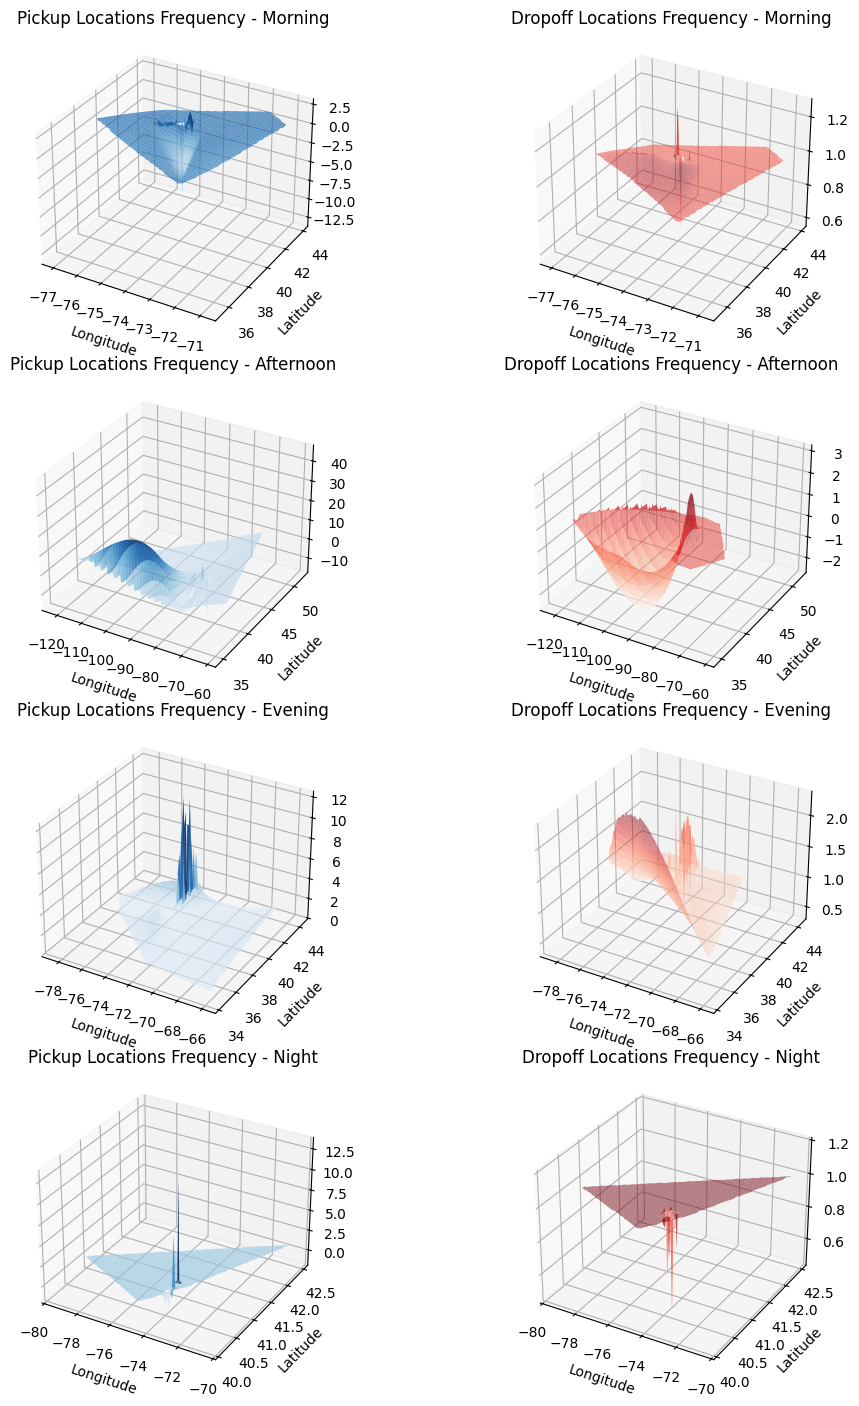

In [23]:
from scipy.interpolate import griddata # For 3D interpolation

fig = plt.figure(figsize=(12, 14))

# Define time zones for plotting
time_zones = ['Morning', 'Afternoon', 'Evening', 'Night']

for i, zone in enumerate(time_zones):
    # Filter data for the current time zone
    zone_data_pickup = trainData[trainData['time_zone'] == zone]
    zone_data_dropoff = trainData[trainData['time_zone'] == zone]

    # Group by pickup coordinates and count frequencies
    pickup_counts = zone_data_pickup.groupby(['pickup_longitude', 'pickup_latitude']).size().reset_index(name='frequency')
    dropoff_counts = zone_data_dropoff.groupby(['dropoff_longitude', 'dropoff_latitude']).size().reset_index(name='frequency')

    # Create grid points for interpolation
    grid_lon = np.linspace(pickup_counts['pickup_longitude'].min(), pickup_counts['pickup_longitude'].max(), 100)
    grid_lat = np.linspace(pickup_counts['pickup_latitude'].min(), pickup_counts['pickup_latitude'].max(), 100)
    grid_lon, grid_lat = np.meshgrid(grid_lon, grid_lat)

    # Interpolate pickup frequencies onto the grid
    grid_freq_pickup = griddata((pickup_counts['pickup_longitude'], pickup_counts['pickup_latitude']),
                                 pickup_counts['frequency'], (grid_lon, grid_lat), method='cubic')

    # Interpolate dropoff frequencies onto the grid
    grid_freq_dropoff = griddata((dropoff_counts['dropoff_longitude'], dropoff_counts['dropoff_latitude']),
                                  dropoff_counts['frequency'], (grid_lon, grid_lat), method='cubic')

    # Plotting Pickup Frequency Surface for the current time zone
    ax1 = fig.add_subplot(4, 2, i*2 + 1, projection='3d')  # Pickup plots in odd indices (1, 3, 5, 7)
    ax1.plot_surface(grid_lon, grid_lat, grid_freq_pickup, cmap='Blues', alpha=0.7)
    ax1.set_title(f'Pickup Locations Frequency - {zone}')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    
    # Plotting Dropoff Frequency Surface for the current time zone
    ax2 = fig.add_subplot(4, 2, i*2 + 2, projection='3d')  # Dropoff plots in even indices (2, 4, 6, 8)
    ax2.plot_surface(grid_lon, grid_lat, grid_freq_dropoff, cmap='Reds', alpha=0.5)
    ax2.set_title(f'Dropoff Locations Frequency - {zone}')
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')

plt.tight_layout()
plt.show()

# The project can be viewed on my Github as well. : https://github.com/devilunraveled/Kaggle_NYTaxiTripDuration